In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/ml/ha12")
os.getcwd()
import torch
import platform
import sys

'/content/drive/MyDrive/Colab Notebooks/ml/ha12'

In [ ]:
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from PIL import Image
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = "cuda" if torch.cuda.is_available() else "cpu"
as_numpy = lambda x: x.detach().cpu().numpy()

jet = matplotlib.colormaps["jet"]
jet_colors = jet(np.arange(256))[:, :3]

def plot_result(ax, img, saliency, label = ""):
    img = np.array(img, dtype = float) / 255.0

    saliency = F.interpolate(saliency, size = img.shape[:2], mode = "bilinear")
    saliency = as_numpy(saliency)[0, 0]
    saliency = saliency - saliency.min()
    saliency = np.uint8(255 * saliency / saliency.max())
    heatmap = jet_colors[saliency]
    ax.imshow(0.5 * heatmap + 0.5 * img)
    ax.axis("off")
    ax.set_title(label)

image_shape = (224, 224)

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

with open("./images_with_labels/imagenet_class_index.json") as f:
    indx2label = json.load(f)


def decode_predictions(preds, k=5):
    return [
        [(*indx2label[str(i)], i, pred[i]) for i in pred.argsort()[::-1][:k]]
        for pred in as_numpy(preds)
    ]

class Probe:
    def get_hook(self,):
        self.data = []
        def hook(module, input, output):
            self.data.append(output)
        return hook

img = Image.open("./images_with_labels/10_n02966193_carousel.png")
img = img.convert("RGB")


x = transform(img)[None]
x = x.to(device)

print("loading the model...")
model = models.vgg16(pretrained=True)

model.eval()
model.to(device)

probe = Probe()

handle = model.features[-1].register_forward_hook(probe.get_hook())


logits = model(x)
preds = logits.softmax(-1)

print("the prediction result:")
for tag, label, i, prob in decode_predictions(preds)[0]:
    print(f"{tag} {label:16} {i:5} {prob:6.2%}")

loading the image...
loading the model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


the prediction result:
n02966193 carousel           476 100.00%
n04462240 toyshop            865  0.00%
n04200800 shoe_shop          788  0.00%
n03947888 pirate             724  0.00%
n03089624 confectionery      509  0.00%


In [ ]:
N = 3

targets = preds.argsort(descending=True)[0, :N]

output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

for i, target in enumerate(targets):
    print(f"Calculating the saliency of the {i+1}-th likely class...")
    target = target.item()

    last_conv_output = probe.data[0]
    last_conv_output.retain_grad()

    logits[0, target].backward(retain_graph=True)
    grad = last_conv_output.grad
    weight = grad.mean(dim=(-1, -2), keepdim=True)
    saliency = (last_conv_output * weight).sum(dim=1, keepdim=True)
    saliency = saliency.clamp(min=0)
    last_conv_output.grad.data.zero_()

    fig, ax = plt.subplots()
    plot_result(ax, img, saliency, "grad_cam on {} {}".format(*indx2label[str(target)]))

    output_path = os.path.join(output_folder, f"02grad_cam_{i+1}_class_{target}.png")
    plt.savefig(output_path)
    plt.close(fig)


Calculating the saliency of the 1-th likely class...
Calculating the saliency of the 2-th likely class...
Calculating the saliency of the 3-th likely class...
Grad-CAM results saved in: results


In [ ]:
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable

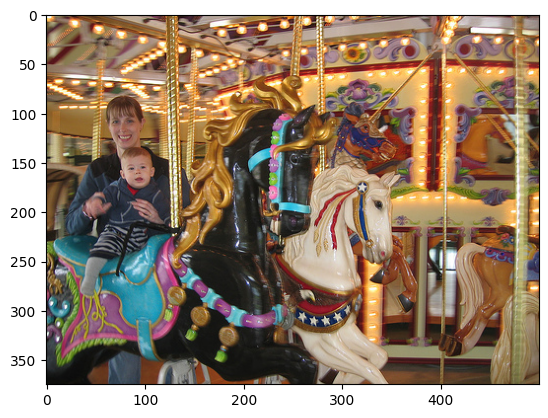

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

img = get_image("./images_with_labels/10_n02966193_carousel.png")
plt.imshow(img)

In [ ]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

In [ ]:
model = models.vgg16(pretrained=True)

In [ ]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./images_with_labels/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [ ]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [ ]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((1.0, 476, 'carousel'),
 (4.5306345e-12, 865, 'toyshop'),
 (7.646496e-13, 788, 'shoe_shop'),
 (2.0518218e-13, 724, 'pirate'),
 (7.9118664e-14, 509, 'confectionery'))

In [ ]:
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

476

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import os

output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

for i in range(3):
    temp1, mask1 = explanation.get_image_and_mask(
        explanation.top_labels[i],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    temp2, mask2 = explanation.get_image_and_mask(
        explanation.top_labels[i],
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    img_boundry1 = mark_boundaries(temp1 / 255.0, mask1)
    img_boundry2 = mark_boundaries(temp2 / 255.0, mask2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_boundry1)
    axes[0].set_title(f"Positive Contribution - Top{i+1}")
    axes[0].axis("off")

    axes[1].imshow(img_boundry2)
    axes[1].set_title(f"Not Positive-Only Contribution - Top{i+1}")
    axes[1].axis("off")

    output_path = os.path.join(output_folder, f"02lime_explanation_top_{i+1}.png")
    plt.savefig(output_path)
    plt.close(fig)

    print(f"Saved explanation for Top-{i+1} class at {output_path}")

Saved explanation for Top-1 class at results/02lime_explanation_top_1.png
Saved explanation for Top-2 class at results/02lime_explanation_top_2.png
Saved explanation for Top-3 class at results/02lime_explanation_top_3.png
All explanations saved in: results
